In [30]:
# Process ACi Data and Verify the Printed Curves are Those Desired to Fit
################# User Settings #################

fitting_group_folder_path = "data/raw/aci/curves/romaine"
species_to_fit = "Romaine"
species_variety = "Bondi SS"

#################################################

# Walk through directory with ACi curves and compile file paths to the LI-6800 plain text files (those without extensions)
import os
path = fitting_group_folder_path
species = species_to_fit
var = species_variety
curvefiles = []
for root,dirs,files in os.walk(path):
    for file in files:
        if not file.endswith(".xlsx"):
            if file[-1].isdigit():
                full_path = os.path.join(root,file)
                curvefiles.append(full_path)

# Add .txt to files
for file_path in curvefiles:
    print(file_path)

for filename in curvefiles:
    if '.' not in filename: 
        new_filename = filename + '.txt'
        print(new_filename)
        os.rename(filename,new_filename)

# Verify files to be fit into ACi fitter
curvefiles = []
for root,dirs,files in os.walk(path):
    for file in files:
        if file.endswith(".txt"):
            full_path = os.path.join(root,file)
            curvefiles.append(full_path)

for i, file in enumerate(curvefiles):
    print(file)

data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi_BB/2025-01-09-1152_Q2000_T15.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi_BB/2025-01-09-1140_Q2000_T20.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi_BB/2025-01-09-1306_Q2000_T33.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi_BB/2025-01-09-1056_Q2000_T30.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi_BB/2025-01-09-1041_Q2000_T25.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi_BB/2025-01-09-1223_Q2000_T23.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi/2025-01-09-1256_Q2000_T32.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi/2025-01-09-1118_T25_Q600.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi/2025-01-09-1141_T25_Q0.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi/2025-01-09-1129_T25_Q200.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi/2025-01-09-1037_aci_T25_Q2000.txt
data/raw/aci/curves/romaine/2025-01-09_Romaine_Bondi/2025-01-09-1051_T

In [31]:
# Concatenate all A-Ci Curve Data into a Dataframe

import pandas as pd
rows_to_skip = 66            # Number of rows to skip at the top of LI-6800 file (header data)
all_data = pd.DataFrame()

for i, infile in enumerate(curvefiles):

    df = pd.read_csv(infile, skiprows=66, delimiter="\t")
    df = df.drop(0) # Drop Units row
    df = df.loc[:, ['A', 'Ci', 'Qin', 'Tleaf']]
    df[['A', 'Ci', 'Qin', 'Tleaf']] = df[['A', 'Ci', 'Qin', 'Tleaf']].apply(pd.to_numeric, errors='coerce').fillna(0) # Clean, fill NaNs
    df['CurveID'] = i + 1
    all_data = pd.concat([all_data, df], ignore_index=True)

all_data['FittingGroup'] = 1
all_data.to_csv("data/processed/aci/"+species+var+"Curves.csv", index=False)

In [32]:
# Fit the Data in the Dataframe to FvCB Model using PhoTorch

######### User Settings ##########
LightResponseType = 2
TemperatureResponseType = 2
FitGamma = False
FitKc = False
FitKo = False
Fitgm = False
###################################

import fitaci
import torch
import pandas as pd
df = all_data
lcd = fitaci.initD.initLicordata(df,preprocess=True)
device_fit = 'cpu'
lcd.todevice(torch.device(device_fit))
if(var==""):
    print(f"Fitting {species}")
else:
    print(f"Fitting {species} var. {var}")
fvcb = fitaci.initM.FvCB(lcd,LightResp_type=LightResponseType,TempResp_type=TemperatureResponseType, onefit=True, fitgamma = FitGamma, fitKc=FitKc, fitKo=FitKo, fitgm=Fitgm)
fitresult = fitaci.run(fvcb, learn_rate= 0.08, device=device_fit, maxiteration = 10000, minloss= 1, recordweightsTF=False)
fvcb = fitresult.model

Done reading: 13 A/Ci curves; 3406 data points
Fitting Romaine var. Bondi SS
Light response type 2: alpha and theta will be fitted.
Temperature response type 2: dHa_Jmax, dHa_TPU, Topt_Vcmax, Topt_Jmax, Topt_TPU will be fitted.
Loss at iter 199: 104.7624
Loss at iter 399: 95.2802
Loss at iter 599: 90.9152
Loss at iter 799: 88.9963
Loss at iter 999: 85.3851
Loss at iter 1199: 101.0529
Loss at iter 1399: 88.9560
Loss at iter 1599: 129.7920
Loss at iter 1799: 90.4778
Loss at iter 1999: 83.0056
Loss at iter 2199: 123.2720
Loss at iter 2399: 89.5873
Loss at iter 2599: 125.3088
Loss at iter 2799: 83.0214
Loss at iter 2999: 82.1288
Loss at iter 3199: 96.3804
Loss at iter 3399: 92.7234
Loss at iter 3599: 82.9839
Loss at iter 3799: 77.5550
Loss at iter 3999: 74.3316
Loss at iter 4199: 72.2831
Loss at iter 4399: 70.8873
Loss at iter 4599: 69.9209
Loss at iter 4799: 69.2784
Loss at iter 4999: 68.8448
Loss at iter 5199: 68.5910
Loss at iter 5399: 68.3892
Loss at iter 5599: 68.2190
Loss at iter 579

In [33]:
# Print Primary Fitted Parameters
print(f"Vcmax25 = {fvcb.Vcmax25[0]}")
print(f"Jmax25 = {fvcb.Jmax25[0]}")
print(f"Vcmax_dHa = {fvcb.TempResponse.dHa_Vcmax[0]}")
print(f"Jmax_dHa = {fvcb.TempResponse.dHa_Jmax[0]}")
print(f"alpha = {fvcb.LightResponse.alpha[0]}")
if(LightResponseType==2):
    print(f"theta = {fvcb.LightResponse.theta[0]}")
if(Fitgm):
    print(f"gm = {fvcb.gm[0]}")
if(FitGamma):
    print(f"Gamma25 = {fvcb.Gamma25[0]}")
if(FitKc):
    print(f"Kc = {fvcb.Kc25[0]}")
if(FitKo):
    print(f"Ko = {fvcb.Ko25[0]}")


Vcmax25 = 143.51058959960938
Jmax25 = 272.7266845703125
Vcmax_dHa = 72.12415313720703
Jmax_dHa = 46.19755935668945
alpha = 0.25419992208480835
theta = 0.7862278819084167


In [34]:
# Save All Parameters to File
savepath = "results/aci/parameters/"+species+var+"Params.csv"
if(LightResponseType==2 & TemperatureResponseType==2):
    vars = ["species","Vcmax25","Jmax25","TPU25","Rd25","alpha","theta","Vcmax_dHa","Vcmax_Topt","Vcmax_dHd","Jmax_dHa","Jmax_Topt","Jmax_dHd","TPU_dHa","TPU_Topt","TPU_dHd","Rd_dHa","Gamma25","Gamma_dHa","Kc25","Kc_dHa","Ko25","Ko_dHa","O"]
    vals = [species,fvcb.Vcmax25.item(),fvcb.Jmax25.item(),fvcb.TPU25.item(),fvcb.Rd25.item(),fvcb.LightResponse.alpha.item(),fvcb.LightResponse.theta.item(),fvcb.TempResponse.dHa_Vcmax.item(),fvcb.TempResponse.Topt_Vcmax.item(),fvcb.TempResponse.dHd_Vcmax.item(),fvcb.TempResponse.dHa_Jmax.item(),fvcb.TempResponse.Topt_Jmax.item(),fvcb.TempResponse.dHd_Jmax.item(),fvcb.TempResponse.dHa_TPU.item(),fvcb.TempResponse.Topt_TPU.item(),fvcb.TempResponse.dHd_TPU.item(),fvcb.TempResponse.dHa_Rd.item(),fvcb.Gamma25.item(),fvcb.TempResponse.dHa_Gamma.item(),fvcb.Kc25.item(),fvcb.TempResponse.dHa_Kc.item(),fvcb.Ko25.item(),fvcb.TempResponse.dHa_Ko.item(),fvcb.Oxy.item()]
    outdf = pd.DataFrame([vals],columns=vars)
    outdf.to_csv(savepath,index=False)
elif(LightResponseType==2 & TemperatureResponseType==1):
    vars = ["species","Vcmax25","Jmax25","TPU25","Rd25","alpha","theta","Vcmax_dHa","Vcmax_Topt","Vcmax_dHd","Jmax_dHa","Jmax_Topt","Jmax_dHd","TPU_dHa","TPU_Topt","TPU_dHd","Rd_dHa","Gamma25","Gamma_dHa","Kc25","Kc_dHa","Ko25","Ko_dHa","O"]
    vals = [species,fvcb.Vcmax25.item(),fvcb.Jmax25.item(),fvcb.TPU25.item(),fvcb.Rd25.item(),fvcb.LightResponse.alpha.item(),fvcb.LightResponse.theta.item(),fvcb.TempResponse.dHa_Vcmax.item(),99999,1,fvcb.TempResponse.dHa_Jmax.item(),99999,1,fvcb.TempResponse.dHa_TPU.item(),99999,1,fvcb.TempResponse.dHa_Rd.item(),fvcb.Gamma25.item(),fvcb.TempResponse.dHa_Gamma.item(),fvcb.Kc25.item(),fvcb.TempResponse.dHa_Kc.item(),fvcb.Ko25.item(),fvcb.TempResponse.dHa_Ko.item(),fvcb.Oxy.item()]
    outdf = pd.DataFrame([vals],columns=vars)
    outdf.to_csv(savepath,index=False)
elif(LightResponseType==1 & TemperatureResponseType==2):
    vars = ["species","Vcmax25","Jmax25","TPU25","Rd25","alpha","theta","Vcmax_dHa","Vcmax_Topt","Vcmax_dHd","Jmax_dHa","Jmax_Topt","Jmax_dHd","TPU_dHa","TPU_Topt","TPU_dHd","Rd_dHa","Gamma25","Gamma_dHa","Kc25","Kc_dHa","Ko25","Ko_dHa","O"]
    vals = [species,fvcb.Vcmax25.item(),fvcb.Jmax25.item(),fvcb.TPU25.item(),fvcb.Rd25.item(),fvcb.LightResponse.alpha.item(),0.0,fvcb.TempResponse.dHa_Vcmax.item(),fvcb.TempResponse.Topt_Vcmax.item(),fvcb.TempResponse.dHd_Vcmax.item(),fvcb.TempResponse.dHa_Jmax.item(),fvcb.TempResponse.Topt_Jmax.item(),fvcb.TempResponse.dHd_Jmax.item(),fvcb.TempResponse.dHa_TPU.item(),fvcb.TempResponse.Topt_TPU.item(),fvcb.TempResponse.dHd_TPU.item(),fvcb.TempResponse.dHa_Rd.item(),fvcb.Gamma25.item(),fvcb.TempResponse.dHa_Gamma.item(),fvcb.Kc25.item(),fvcb.TempResponse.dHa_Kc.item(),fvcb.Ko25.item(),fvcb.TempResponse.dHa_Ko.item(),fvcb.Oxy.item()]
    outdf = pd.DataFrame([vals],columns=vars)
    outdf.to_csv(savepath,index=False)
elif(LightResponseType==1 & TemperatureResponseType==1):
    vars = ["species","Vcmax25","Jmax25","TPU25","Rd25","alpha","theta","Vcmax_dHa","Vcmax_Topt","Vcmax_dHd","Jmax_dHa","Jmax_Topt","Jmax_dHd","TPU_dHa","TPU_Topt","TPU_dHd","Rd_dHa","Gamma25","Gamma_dHa","Kc25","Kc_dHa","Ko25","Ko_dHa","O"]
    vals = [species,fvcb.Vcmax25.item(),fvcb.Jmax25.item(),fvcb.TPU25.item(),fvcb.Rd25.item(),fvcb.LightResponse.alpha.item(),0.0,fvcb.TempResponse.dHa_Vcmax.item(),99999,1,fvcb.TempResponse.dHa_Jmax.item(),99999,1,fvcb.TempResponse.dHa_TPU.item(),99999,1,fvcb.TempResponse.dHa_Rd.item(),fvcb.Gamma25.item(),fvcb.TempResponse.dHa_Gamma.item(),fvcb.Kc25.item(),fvcb.TempResponse.dHa_Kc.item(),fvcb.Ko25.item(),fvcb.TempResponse.dHa_Ko.item(),fvcb.Oxy.item()]
    outdf = pd.DataFrame([vals],columns=vars)
    outdf.to_csv(savepath,index=False)
else:
    print(f"LightResponseType={LightResponseType}, TemperatureResponseType={TemperatureResponseType}. They should be either 1 or 2.")


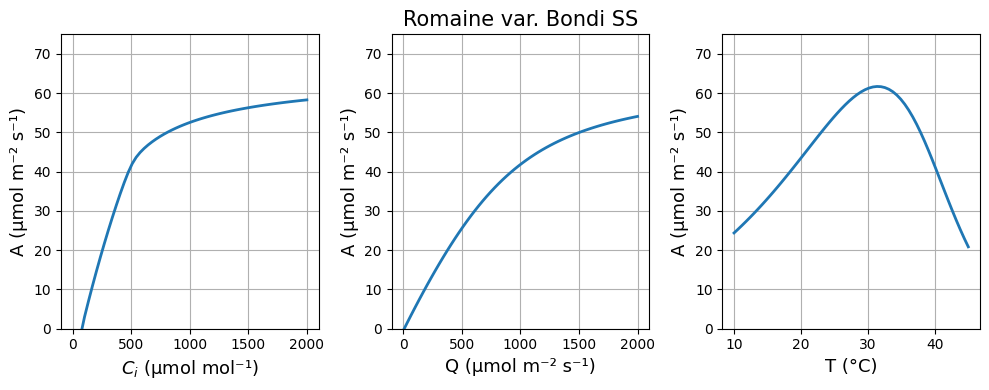

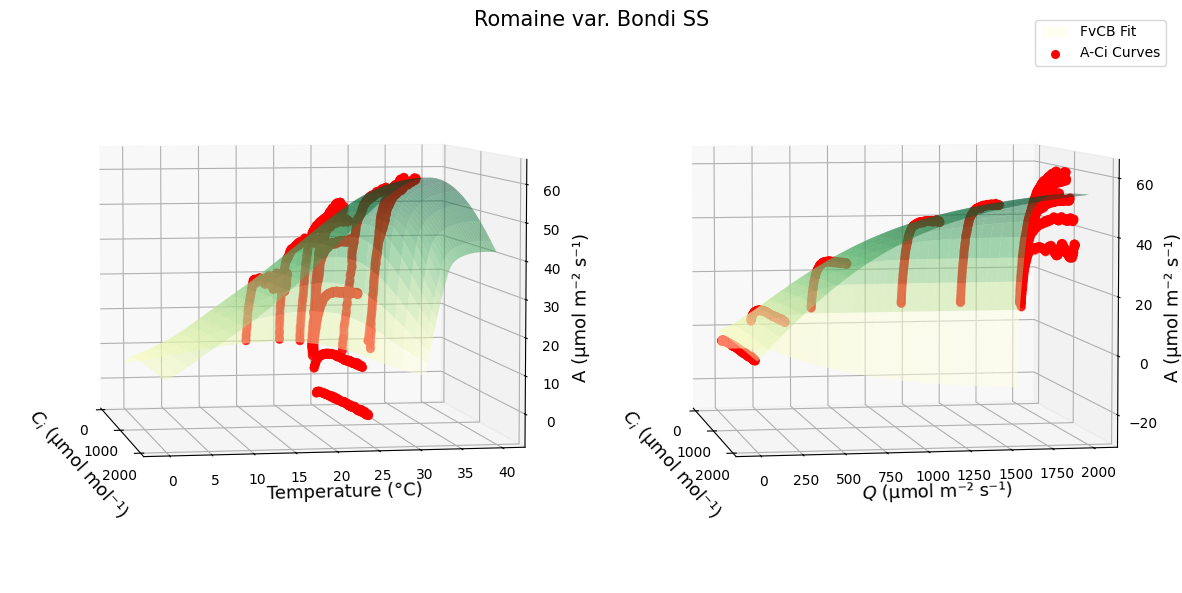

In [35]:
# Plot Fitted Model Response Curves and Model Surfaces against A-Ci Data

############ User Settings ###############
plotSpeciesFitAbove = True
if plotSpeciesFitAbove:
    spps = [species]
    vars = [var]
else:
    spps = ["Romaine", "Iceberg"]
    vars = ["Bondi SS", "Calmar"]
##########################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fvcb import fvcb

for i in range(len(spps)):
    species = spps[i]
    try:
        var = vars[i]
    except:
        var = ""
    P = pd.read_csv(f"results/aci/parameters/{species+var}Params.csv")  # Load parameter table
    
    # Create a figure with specific size
    plt.figure(figsize=(10, 4))

    # A vs Ci @ Q2000, T = 35 °C
    Ci = np.linspace(0, 2000, 60)
    T = (35 + 273.15) * np.ones_like(Ci)
    Q = 2000 * np.ones_like(T)
    Ci, Q, T = np.meshgrid(Ci, Q, T)

    plt.subplot(1, 3, 1)
    for _, row in P.iterrows():
        p = row  # Extract parameter set
        x = np.column_stack((Ci.ravel(), Q.ravel(), T.ravel()))
        A = fvcb(x, p)
        A = A.reshape(60, 60, 60)
        x_vals = Ci[0, :, 0]
        y_vals = A[0, :, 0]
        plt.plot(x_vals, y_vals, linewidth=2)

    plt.xlabel("$C_i$ (µmol mol⁻¹)", fontsize=13)
    plt.ylabel("A (µmol m⁻² s⁻¹)", fontsize=13)
    plt.ylim([0, 75])
    plt.grid(True)

    # A vs Q @ T = 25 °C, Ci = 0.7 * 420
    Q = np.linspace(0, 2000, 60)
    T = (25 + 273.15) * np.ones_like(Q)
    Ci = 2000 * np.ones_like(T)
    Ci, Q, T = np.meshgrid(Ci, Q, T)

    plt.subplot(1, 3, 2)
    for _, row in P.iterrows():
        p = row
        x = np.column_stack((Ci.ravel(), Q.ravel(), T.ravel()))
        A = fvcb(x, p)
        A = A.reshape(60, 60, 60)
        x_vals = Q[:, 0, 0]
        y_vals = A[:, 0, 0]
        plt.plot(x_vals, y_vals, linewidth=2)

    plt.xlabel("Q (µmol m⁻² s⁻¹)", fontsize=13)
    plt.ylabel("A (µmol m⁻² s⁻¹)", fontsize=13)
    if(var==""):
        plt.title(f"{species}", fontsize=15)
    else:
        plt.title(f"{species} var. {var}", fontsize=15)
    plt.ylim([0, 75])
    plt.grid(True)

    # A vs T @ Q = 2000, Ci = 0.7 * 420
    T = np.linspace(10, 45, 60) + 273.15
    Ci = 2000 * np.ones_like(T)
    Q = 2000 * np.ones_like(T)
    Ci, Q, T = np.meshgrid(Ci, Q, T)

    plt.subplot(1, 3, 3)
    for _, row in P.iterrows():
        p = row
        x = np.column_stack((Ci.ravel(), Q.ravel(), T.ravel()))
        A = fvcb(x, p)
        A = A.reshape(60, 60, 60)
        x_vals = T[0, 0, :] - 273.15
        y_vals = A[0, 0, :]
        plt.plot(x_vals, y_vals, linewidth=2)

    plt.xlabel("T (°C)", fontsize=13)
    plt.ylabel("A (µmol m⁻² s⁻¹)", fontsize=13)
    plt.ylim([0, 75])
    plt.grid(True)

    plt.tight_layout()
    plt.show()


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from fvcb import fvcb 


for i in range(len(spps)):
    species = spps[i]
    try:
        var = vars[i]
    except:
        var = ""

    # Load data and parameters
    data = pd.read_csv(f"data/processed/aci/{species+var}Curves.csv")  # ACi data
    P = pd.read_csv(f"results/aci/parameters/{species+var}Params.csv")    # Model parameters

    # Create a grid for Ci and T
    Ci = np.linspace(100, 2000, 60)            # Range of Ci values
    T = np.linspace(273, 40 + 273, 60)         # Temperature range in Kelvin
    Ci, T = np.meshgrid(Ci, T)                 # Create a grid
    Q = 2000 * np.ones_like(T)                 # Constant light intensity

    # First subplot: A vs Ci and T at Q = 2000
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    
    p = P.iloc[0].to_dict()  # Extract the first parameter set as a dictionary
    x = np.column_stack((Ci.ravel(), Q.ravel(), T.ravel()))
    A = fvcb(x, p)  # Run the FvCB model
    A = A.reshape(Ci.shape)  # Reshape to match the grid

    # Plot the surface
    surf = ax1.plot_surface(Ci, T - 273.15, A, cmap='YlGn', edgecolor='none', alpha=0.5, label="FvCB Fit")
    ax1.set_xlabel("$C_i$ (µmol mol⁻¹)", fontsize=13)
    ax1.set_ylabel("Temperature (°C)", fontsize=13)
    ax1.set_zlabel("A (µmol m⁻² s⁻¹)", fontsize=13)
    ax1.view_init(elev=5, azim=-10)

    # Overlay experimental data
    ax1.scatter(data["Ci"], data["Tleaf"], data["A"], c='r', s=30, label="A-Ci Curves")
    ax1.set_xticks([0,1000,2000])


    # Second subplot: A vs Ci and Q at T = 298.15 K
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    Ci = np.linspace(5, 2000, 60)
    Q = np.linspace(0, 2000, 60)
    Ci, Q = np.meshgrid(Ci, Q)
    T = 298.15 * np.ones_like(Ci)  # Constant temperature at 298.15 K

    x = np.column_stack((Ci.ravel(), Q.ravel(), T.ravel()))
    A = fvcb(x, p)
    A = A.reshape(Ci.shape)

    # Plot the surface
    surf = ax2.plot_surface(Ci, Q, A, cmap='YlGn', edgecolor='none', alpha=0.5,label="FvCB Fit")
    ax2.set_xlabel("$C_i$ (µmol mol⁻¹)", fontsize=13)
    ax2.set_ylabel("$Q$ (µmol m⁻² s⁻¹)", fontsize=13)
    ax2.set_zlabel("A (µmol m⁻² s⁻¹)", fontsize=13)
    ax2.view_init(elev=5, azim=-10)


    # Overlay experimental data
    ax2.scatter(data["Ci"], data["Qin"], data["A"], c='r', s=30,label="A-Ci Curves")
    ax2.set_xticks([0,1000,2000])
    ax2.legend(loc="upper right")

    plt.tight_layout()
    if(var==""):
        plt.suptitle(f"{species}", fontsize=15)
    else:
        plt.suptitle(f"{species} var. {var}", fontsize=15)
    plt.show()